# Not Hotdog

---

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(1)

%load_ext autoreload
%autoreload 2
%aimport utils

# Select GPU
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

/home/ubuntu/anaconda3/envs/tf18/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2435397745742639057, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11285974221
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10016967326659473660
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"]

_(many functions were placed in `utils.py` in order to make the code cleaner and I will import them directly from that file)_

## Data loading and image representation

In [2]:
from PIL import Image

data_folder = "./data/"

path = data_folder + "hot_dog/893996.jpg"

# read image
image = Image.open(path)

# resize image
height = 299
width = 299
image = image.resize((height, width))

# transform the image to array
image = np.array(image)

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [3]:
image.shape

(299, 299, 3)

We can visualize the loaded image using

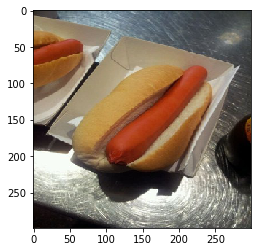

In [4]:
plt.figure(figsize=(4,4))
plt.imshow(image)

### Read images and resize them

I create a function inside `utils` to read images from a given path and resize them to have the every image on the dataset with the same width and height.

Use the defined `read_images_from_path` function to read and resize all training and test images.

In [19]:
from utils import read_images_from_path

# define paths
img_hot_dog_path = data_folder + 'hotdog'
img_not_hot_dog_path = data_folder + 'not_hotdog'

# get images
img_hot_dog = read_images_from_path(img_hot_dog_path, height, width)
img_not_hot_dog = read_images_from_path(img_not_hot_dog_path, height, width)

Getting images from path: ./data/hot_dog...
Getting images from path: ./data/not_hot_dog...


Create `X_train`, `Y_train`, `X_test` and `Y_test` partitions.

In [20]:
from sklearn.model_selection import train_test_split

test_split_size = 0.2

img_hot_dog_train, img_hot_dog_test, \
tag_hot_dog_train, tag_hot_dog_test = train_test_split(img_hot_dog,
                                                       len(img_hot_dog) * [0],
                                                       test_size=test_split_size,
                                                       random_state=1)

img_not_hot_dog_train, img_not_hot_dog_test, \
tag_not_hot_dog_train, tag_not_hot_dog_test = train_test_split(img_not_hot_dog,
                                                               len(img_not_hot_dog) * [1],
                                                               test_size=test_split_size,
                                                               random_state=1)

In [21]:
X_train = np.asarray(img_hot_dog_train + img_not_hot_dog_train)
Y_train = np.asarray(tag_hot_dog_train + tag_not_hot_dog_train)

X_test = np.asarray(img_hot_dog_test + img_not_hot_dog_test)
Y_test = np.asarray(tag_hot_dog_test + tag_not_hot_dog_test)

#print(X_train[0].shape)
#print(Y_train)

If everything has been properly loaded both X_train and Y_train lists should have equal length, and the same should happen for the pair X_test and Y_test.

In [22]:
print("X_train size", len(X_train))
print("Y_train size", len(Y_train))
print("X_test size", len(X_test))
print("Y_test size", len(Y_test))

class_names = ['Hot dog', 'Not hot dog']

X_train size 768
Y_train size 768
X_test size 193
Y_test size 193


Show some **Hot dog** images:

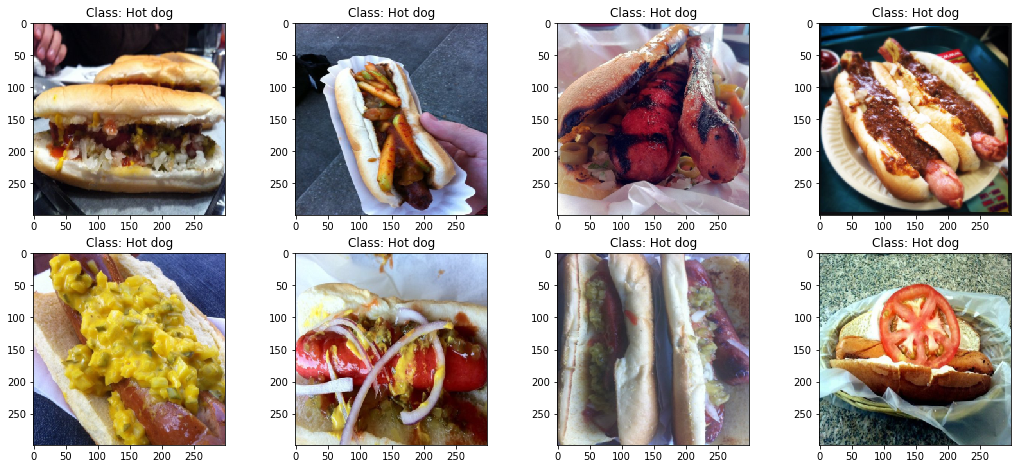

In [23]:
plt.figure(figsize=(18, 12))

for i in range(0, 8):
    image_index = i
    Y_test_binary = Y_train[image_index]

    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[image_index])
    plt.title('Class: {}'.format(class_names[Y_test_binary]))
    
# show the plot
plt.show()

Show some **Not hot dog** images:

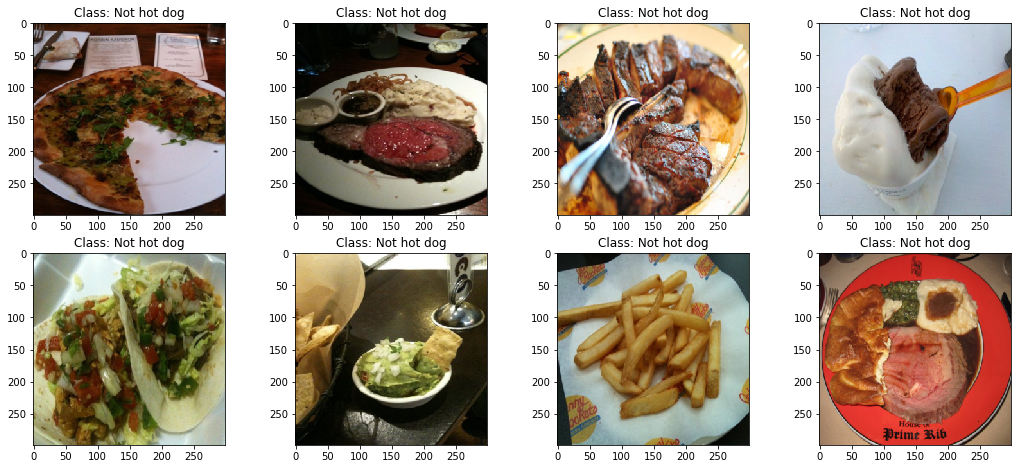

In [24]:
plt.figure(figsize=(18, 12))

for i in range(0, 8):
    image_index = i + len(img_hot_dog_train)
    Y_test_binary = Y_train[image_index]

    plt.subplot(3, 4, i+1)
    plt.imshow(X_train[image_index])
    plt.title('Class: {}'.format(class_names[Y_test_binary]))
    
# show the plot
plt.show()

## Data preprocessing

For efficiency in batch processing, in keras all input patterns should have equal dimensions. Even more, when working with images keras expects as training input a 4-dimensional matrix with dimensions (patterns, image_width, image_height, color_channels). Therefore, you must preprocess the data into this format. It is also highly recommended to rescale the pixel values to make them lie in the range [0,1]. Finally, you might also need to perform some transformation on the outputs Y.

In [25]:
from keras.utils import np_utils

# images are already resized to 30x40 pixels

# normalize data: rescale pixel values to the range [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# we should change the class encoding to something more akin to neural networks,
# instead of having a single integer ranging [0,1] to encode the different classes,
# we will use a one-hot vector encoder to codify that 2 classes
n_classes = 2

Y_train = np_utils.to_categorical(Y_train, n_classes)
Y_test = np_utils.to_categorical(Y_test, n_classes)

In [26]:
# preprocess the data into [patterns, image_width, image_height, color_channels] format
color_channels = X_train.shape[3]
train_patterns = X_train.shape[0]
test_patterns = X_test.shape[0]

train_tensor = X_train.reshape(train_patterns, width, height, color_channels)
test_tensor = X_test.reshape(test_patterns, width, height, color_channels)

print('train_tensor.shape: {}'.format(train_tensor.shape))
print('Y_train.shape: {}'.format(Y_train.shape))

print('test_tensor.shape: {}'.format(test_tensor.shape))
print('Y_test.shape: {}'.format(Y_test.shape))

train_tensor.shape: (768, 299, 299, 3)
Y_train.shape: (768, 2)
test_tensor.shape: (193, 299, 299, 3)
Y_test.shape: (193, 2)


## Deep model

Create a deep network that solves the classification problem using the layers that seem fit for problem.

### Convolutional network configuration

In [30]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, Convolution2D, MaxPooling2D
from keras.optimizers import Adam

def build_model():
    model = Sequential()

    model.add(Convolution2D(32, (3, 3),
                            input_shape=(width, height, color_channels),
                            activation='relu'))
    model.add(Convolution2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    #model.add(Convolution2D(64, (3, 3), activation='relu'))
    #model.add(Convolution2D(64, (3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.4))

    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])

    return model

In [35]:
####### PRETRAINED FINE TUNNING
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model


def build_model():
    base_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(width, height, color_channels))
    
    # we chose to train the top 2 inception blocks, i.e. we will freeze from the mixed8 layer
    # Then, freeze the first 249 layers and unfreeze the rest:        
    #for layer in base_model.layers[:249]:
    for layer in base_model.layers:
        layer.trainable = False
    #for layer in base_model.layers[249:]:
    #    layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)

    predictions = Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])

    return model

In [36]:
import numpy as np
np.random.seed(1) # for reproducibility

model = build_model()

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_189 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_189 (BatchN (None, 149, 149, 32) 96          conv2d_189[0][0]                 
__________________________________________________________________________________________________
activation_189 (Activation)     (None, 149, 149, 32) 0           batch_normalization_189[0][0]    
__________________________________________________________________________________________________
conv2d_190

In [37]:
%%time

epochs = 25
batch_size = 32

model_history = model.fit(
    train_tensor,
    Y_train,
    steps_per_epoch = len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(test_tensor, Y_test),
    validation_steps = len(X_test) // batch_size,
    verbose=1
)

Train on 768 samples, validate on 193 samples
Epoch 1/25
24/24 [==============================] - 224s 9s/step - loss: 0.6561 - acc: 0.6072 - val_loss: 0.5934 - val_acc: 0.6632
Epoch 2/25
24/24 [==============================] - 201s 8s/step - loss: 0.5572 - acc: 0.7491 - val_loss: 0.4801 - val_acc: 0.8290
Epoch 3/25
24/24 [==============================] - 201s 8s/step - loss: 0.4836 - acc: 0.8219 - val_loss: 0.4064 - val_acc: 0.8756
Epoch 4/25
24/24 [==============================] - 200s 8s/step - loss: 0.4292 - acc: 0.8531 - val_loss: 0.3585 - val_acc: 0.9016
Epoch 5/25
24/24 [==============================] - 201s 8s/step - loss: 0.3874 - acc: 0.8844 - val_loss: 0.3270 - val_acc: 0.9016
Epoch 6/25
24/24 [==============================] - 201s 8s/step - loss: 0.3542 - acc: 0.8998 - val_loss: 0.3060 - val_acc: 0.9067
Epoch 7/25
24/24 [==============================] - 202s 8s/step - loss: 0.3270 - acc: 0.9113 - val_loss: 0.2920 - val_acc: 0.9119
Epoch 8/25
24/24 [===================

193/193 [==============================] - 3s 13ms/step
Test loss 0.3030146880345564
Test accuracy 0.8808290155440415


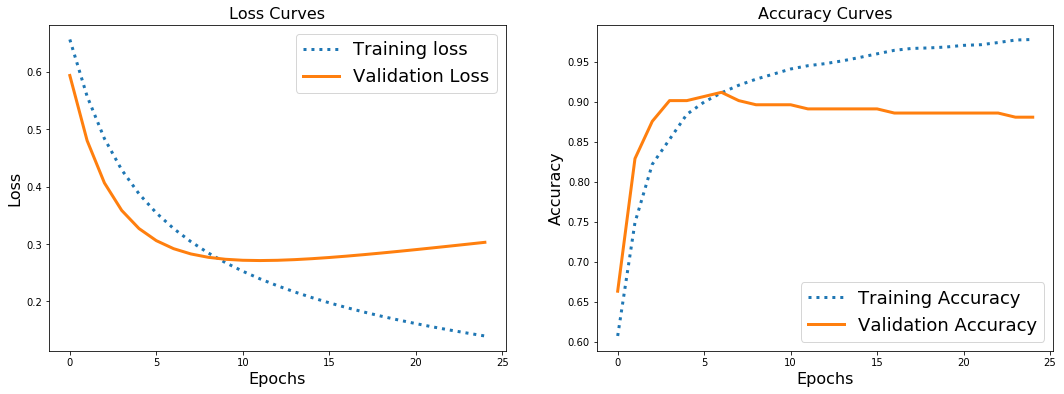

In [38]:
from utils import plot_loss_and_accuracy

score = model.evaluate(test_tensor, Y_test)
print("Test loss", score[0])
print("Test accuracy", score[1])

plot_loss_and_accuracy(model_history)

In this case adding more epochs ends making the model overfit (increasing the test loss), so I keep 20 epochs.

In [50]:
#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
preds = model.predict(test_tensor)
preds = np.argmax(preds, axis=1)

Y_test_binary = np.argmax(Y_test,axis=1)
confusion_matrix = confusion_matrix(Y_test_binary, preds)

confusion_matrix

array([[93,  0],
       [23, 77]])

### Show some images for which the model fails

Although we've got a pretty good test accuracy, the remaining percentage of images may fail, out model is not 100% effective _–and these models don't exist–_.

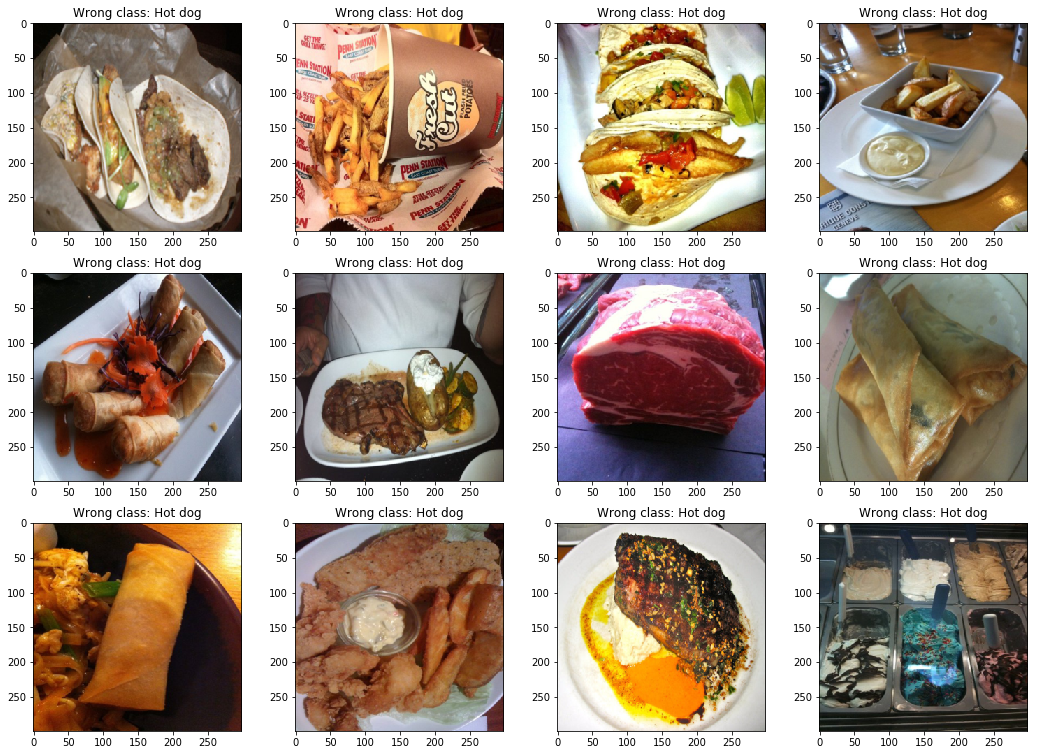

In [52]:
correct_predictions = preds == Y_test_binary
incorrect_images = test_tensor[~correct_predictions]
incorrect_images_index = [i for i, x in enumerate(correct_predictions) if not x]

plt.figure(figsize=(18, 36))
X_batch=[]

for i in range(0, 12):
    plt.subplot(8, 4, i+1)
    plt.imshow(incorrect_images[i])

    incorrect_image_pred_position = incorrect_images_index[i]
    incorrect_image_class = class_names[preds[incorrect_image_pred_position]]
    plt.title('Wrong class: {}'.format(incorrect_image_class))

# show the plot
plt.show()

---